### Import

In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import math
# matplotlib
import matplotlib.pyplot as plt

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# statistics kit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                                      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

### AR Data

In [3]:
mode = 'max'
# df = pd.read_csv(path_to_out + 'DJF_ivt_ar_types_freezing_level_max_prec_new.csv')
df = pd.read_csv(path_to_out + 'DJF_ivt_ar_types_freezing_level_max_prec_20230217.csv')
ylim_max = 375
## some maintenence for the df 
## add month and year columns
df = df.drop(columns=['Unnamed: 0'])
frame = pd.to_datetime(df.start_date.values)
frame = pd.DataFrame([frame]).transpose()
frame['date']= frame
df['month']= frame['date'].dt.month
df['year']= frame['date'].dt.year

# ## select only AR events that resulted in more than 0.1 mm of rainfall per event
# idx = (df.prec > 0.1)
# df = df.loc[idx]
# print(len(df))

# ## make single column for freezing level
# arcat_lst = [1, 2, 3]
refcol_lst = ['western', 'northwestern', 'eastern']

# df['freeze'] = 0

# df.loc[df['ar_cat'] == 1, 'freeze'] = df['western_freeze']
# df.loc[df['ar_cat'] == 2, 'freeze'] = df['northwestern_freeze']
# df.loc[df['ar_cat'] == 3, 'freeze'] = df['eastern_freeze']

## fix ivtdir - get rid of units and convert to float
df['ivtdir_new'] = df['ivtdir'].apply(lambda x: float(x.strip(" degree")))

<AxesSubplot:>

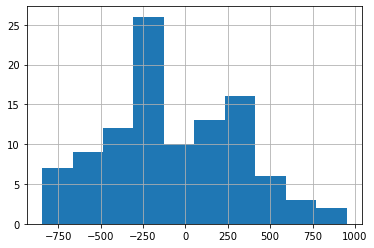

In [14]:
df.loc[(df['ar_cat'] == 1) & (df['prec'] > 20)].freeze.hist()

In [11]:
df.loc[df['ar_cat'] == 1].freeze.std()

413.27860689894413

In [4]:
# arid = 101040 # feb2011b
# arid = 101129 # feb2011c
arid = 101168.0 # feb2011 101168.0
# arid = 94008.0 # dec 2008
# arid = 40590.
arid = 31016 # jan 1989
# arid = 37230
arid = 97756.0 # feb 2010
df.loc[(df.trackID == arid)]



,trackID,ar_cat,start_date,end_date,duration,landslideID,landslide_lat,landslide_lon,ivt,ivtdir,freeze,prec,month,year,ivtdir_new
406,97756.0,1.0,2010-02-06 00:00:00,2010-02-08 18:00:00,66.0,1488.0,34.0049,73.7526,453.792586,175.6797282262202 degree,-140.883130,188.671875,2,2010,175.679728
407,97756.0,1.0,2010-02-06 00:00:00,2010-02-08 18:00:00,66.0,1489.0,34.8733,72.6625,453.792586,175.6797282262202 degree,-140.883130,188.671875,2,2010,175.679728
408,97756.0,2.0,2010-02-04 12:00:00,2010-02-06 00:00:00,36.0,1488.0,34.0049,73.7526,370.036253,260.5767017011086 degree,115.315865,74.124634,2,2010,260.576702
409,97756.0,2.0,2010-02-04 12:00:00,2010-02-06 00:00:00,36.0,1489.0,34.8733,72.6625,370.036253,260.5767017011086 degree,115.315865,74.124634,2,2010,260.576702


In [5]:
artype_lst = [1, 2, 3]
rsquared = []
case_study = []
freeze_lst = []
for i, ar_type in enumerate(artype_lst):
    
    # select ar category
    idx = (df.ar_cat == ar_type) 
    data1 = df.loc[idx]
    print('AR Type:', refcol_lst[i])
    ## Calculate Linear regression
    # X = data1['ivt'] # single variable
    # X = data1['duration'] # single variable
    # X = data1['ivtdir_new'] # single variable
    X = np.column_stack((data1['ivt'], data1['duration'])) # multiple linear regression
    y = data1['prec']

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2, missing='drop')
    est2 = est.fit()
    print(est2.summary())
    rsquared.append(est2.rsquared)
    
    ## get 85th percentile of ivt and precip
    ivt_thres = data1['ivt'].describe(percentiles=[.85]).loc['85%']
    prec_thres = data1['prec'].describe(percentiles=[.85]).loc['85%']
    
    # select only events above 85th percentile
    idx = (data1['prec'] >= prec_thres) & (data1['ivt'] >= ivt_thres)
    data_new = data1.loc[idx]
    freeze_thres = data_new.freeze.mean()
    freeze_lst.append(freeze_thres) # add threshold for freezing level for each AR type to list
    
    case_study.append(data_new)
    
    print('Number of cases about 85th percentile', len(data_new))

AR Type: western
                            OLS Regression Results                            
Dep. Variable:                   prec   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     464.7
Date:                Fri, 17 Mar 2023   Prob (F-statistic):           1.57e-89
Time:                        13:48:39   Log-Likelihood:                -1280.6
No. Observations:                 282   AIC:                             2567.
Df Residuals:                     279   BIC:                             2578.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.0654      3.078   

<AxesSubplot:>

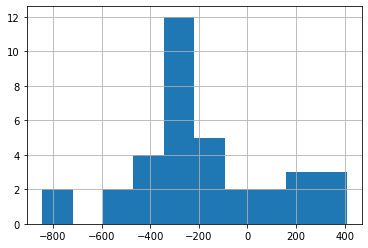

In [9]:
case_study[0].freeze.hist()

In [8]:
case_study[0].freeze.std()

307.0696564980206

In [16]:
print(freeze_lst)

[-181.81542565714284, 218.39773366896554, -279.02235976190474]


In [17]:
## case study selection 
## events that are western AR type, above average freezing level, and precipitation and IVT exceeds 85th percentile
case_study[0].loc[(case_study[0].freeze > freeze_lst[0])]

,trackID,ar_cat,start_date,end_date,duration,landslideID,landslide_lat,landslide_lon,ivt,ivtdir,freeze,prec,month,year,ivtdir_new,freeze_final
124,34284.0,1.0,1990-01-16 00:00:00,1990-01-20 00:00:00,96.0,NaN,NaN,NaN,332.386940,242.88597477590787 degree,150.775670,81.498291,1,1990,242.885975,0
149,37457.0,1.0,1991-01-26 00:00:00,1991-01-28 12:00:00,60.0,NaN,NaN,NaN,367.841585,246.74433429734074 degree,255.987530,174.387573,1,1991,246.744334,0
202,49910.0,1.0,1995-02-10 06:00:00,1995-02-12 00:00:00,42.0,NaN,NaN,NaN,342.539296,219.01041544189803 degree,103.007744,100.473633,2,1995,219.010415,0
252,59206.0,1.0,1998-02-13 00:00:00,1998-02-15 12:00:00,60.0,NaN,NaN,NaN,456.233572,184.78572762381924 degree,-24.238308,129.489746,2,1998,184.785728,0
265,62359.0,1.0,1999-02-22 00:00:00,1999-02-22 18:00:00,18.0,NaN,NaN,NaN,301.406773,245.94406780964053 degree,398.164340,52.131104,2,1999,245.944068,0
270,68106.0,1.0,2000-12-15 12:00:00,2000-12-17 00:00:00,36.0,NaN,NaN,NaN,295.948946,225.05809009798747 degree,253.467010,50.933228,12,2000,225.058090,0
353,84815.0,1.0,2006-02-23 12:00:00,2006-02-26 00:00:00,60.0,NaN,NaN,NaN,330.012181,238.69580215288127 degree,323.748200,121.703613,2,2006,238.695802,0
355,87455.0,1.0,2006-12-02 00:00:00,2006-12-05 00:00:00,72.0,NaN,NaN,NaN,405.442215,193.3127070546972 degree,-133.371480,148.758057,12,2006,193.312707,0
369,88138.0,1.0,2007-02-26 12:00:00,2007-02-28 00:00:00,36.0,NaN,NaN,NaN,352.775118,179.69575703932094 degree,-165.185910,109.686035,2,2007,179.695757,0
376,91004.0,1.0,2008-01-14 00:00:00,2008-01-17 12:00:00,84.0,NaN,NaN,NaN,340.519907,227.46843668758763 degree,-45.137604,99.278198,1,2008,227.468437,0


In [19]:
## events that are western AR type, below average freezing level, and precipitation and IVT exceeds 85th percentile
case_study[0].loc[(case_study[0].freeze < freeze_lst[0])]

,trackID,ar_cat,start_date,end_date,duration,landslideID,landslide_lat,landslide_lon,ivt,ivtdir,freeze,prec,month,year,ivtdir_new,freeze_final
52,12271.0,1.0,1982-12-07 06:00:00,1982-12-09 12:00:00,54.0,NaN,NaN,NaN,327.007993,236.5474373095512 degree,-412.91904,88.043701,12,1982,236.547437,0
58,12649.0,1.0,1983-01-26 12:00:00,1983-01-28 12:00:00,48.0,NaN,NaN,NaN,365.582713,163.8257333202032 degree,-583.68097,106.729004,1,1983,163.825733,0
109,31016.0,1.0,1989-01-04 00:00:00,1989-01-06 12:00:00,60.0,NaN,NaN,NaN,331.370566,167.71987004551556 degree,-769.94640,176.232910,1,1989,167.719870,0
145,37230.0,1.0,1990-12-26 00:00:00,1990-12-29 00:00:00,72.0,NaN,NaN,NaN,456.116887,185.563658703901 degree,-412.99850,274.049561,12,1990,185.563659,0
159,40590.0,1.0,1992-01-22 00:00:00,1992-01-30 00:00:00,192.0,NaN,NaN,NaN,511.340042,181.8431679645318 degree,-267.46840,363.083252,1,1992,181.843168,0
184,43950.0,1.0,1993-02-24 12:00:00,1993-02-26 00:00:00,36.0,NaN,NaN,NaN,297.481825,165.19671913918475 degree,-450.70065,108.970215,2,1993,165.196719,0
224,53118.0,1.0,1996-02-22 00:00:00,1996-02-24 00:00:00,48.0,NaN,NaN,NaN,390.352199,189.32942190180526 degree,-198.58289,77.231934,2,1996,189.329422,0
230,55893.0,1.0,1997-01-18 00:00:00,1997-01-19 00:00:00,24.0,NaN,NaN,NaN,325.568635,157.40266250920394 degree,-844.70540,56.174805,1,1997,157.402663,0
295,74983.0,1.0,2003-02-16 00:00:00,2003-02-17 00:00:00,24.0,NaN,NaN,NaN,312.918473,169.8928850393742 degree,-283.39500,70.100098,2,2003,169.892885,0
296,74922.0,1.0,2003-02-17 00:00:00,2003-02-18 00:00:00,24.0,NaN,NaN,NaN,462.718961,182.27171665917083 degree,-326.89868,160.501343,2,2003,182.271717,0


## Plot IVT/Precip Scatter and IVT direction and precipitation in windrose

Use https://gist.github.com/phobson/41b41bdd157a2bcf6e14 as an example

In [20]:
## Define a function that gives nice labels for precipitation ranges

def range_labels(bins, units):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('clear'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))

    return list(labels)

## Define a function to convert centered angles to left-edge radians
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

## define wind rose function
def wind_rose(ax, rosedata, wind_dirs, legend_req, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])
    else:
        palette = sns.color_palette(palette, n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    if legend_req == True:
        leg = ax.legend(loc=(0.75, 0.2), ncol=1)
    
    return ax

def calc_rose(df, prec_bins, prec_labels, dir_bins, dir_labels):
    '''
    ### Determine the relative percentage of observation in each speed and direction bin
    Here's how we do it:

    - assign a precipitation bin for each row with pandas.cut
    - assign a direction bin for each row (again, pandas.cut)
    - unify the 360° and 0° bins under the 0° label
    - group the data simultaneously on both precipitation and direction bins
    - compute the size of each group
    - unstack (pivot) the speed bins into columns
    - fill missing values with 0
    - assign a "calm" column to be the total number of calm observations evenly distributed across all directions
    - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
    - convert all of the counts to percentages of the total number of observations
    '''
    total_count = df.shape[0]
    calm_count = df.query("prec < 2").shape[0]
    print('Of {} total observations, {} have less than 2 mm of precipitation.'.format(total_count, calm_count))
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=prec_labels, right=True))
          .assign(ivtdir_bins=lambda df: pd.cut(df['ivtdir_new'], bins=dir_bins, labels=dir_labels, right=False))
          .replace({'ivtdir_bins': {360: 0}})
          .groupby(by=['prec_bins', 'ivtdir_bins'])
          .size()
          .unstack(level='prec_bins')
          .fillna(0)
          .assign(clear=lambda df: calm_count / df.shape[0])
          .sort_index(axis=1)
          .applymap(lambda x: x / total_count * 100))
        
    return df

In [ ]:
## update plot so that it is 3 columns (ar type) by 1 rows (location of precip)
fname = path_to_figs + 'wrf_scatter_rose' + mode
fmt = 'png'
nrows = 3
ncols = 2
nplots=nrows*ncols

fig = plt.figure(figsize=(10,15.5))

region_lst = ['western'] + ['northwestern'] + ['eastern']
artype_lst = [1, 2, 3]
plt_lbl = ['(a) Western HMA AR', '(b) Northwestern HMA AR', '(c) Eastern HMA AR']

colors = np.array(([239/256, 86/256, 69/256, 1], # UCSB coral
                   [254/256, 188/256, 17/256, 1], # UCSB gold
                   [4/256, 124/256, 145/256], # UCSB aqua
                   [156/256, 190/256, 190/256], # UCSB mist
                  ), dtype='object')

jan2002ID = 71513
feb2011ID = 101129
feb2010ID = 97756
feb1998ID = 59206
jan1989ID = 31016
id1 = jan1989ID
id2 = feb2010ID
case_study = [(id1, id2), (id1, id2), (id1, id2)]
case_name = ['Jan 1989', 'Feb 2010']


sns.set_style("whitegrid")
legend_lst = [False, False, True]
subplt_no = [1, 3, 5]
for i, ar_type in enumerate(artype_lst):
    ax = fig.add_subplot(nrows, ncols, subplt_no[i])
    
    # plot ALL cases
    idx = (df.ar_cat == ar_type) 
    data1 = df.loc[idx]
    n = len(data1)
    
    # sort data by duration
    test=data1.sort_values('duration')
    test['AR Duration (hours)'] = pd.cut(test["duration"], [0, 25, 50, 100, 150, 300], labels=["< 25", "25-49", "50-99", "100-150", "> 150"])
    cpal = sns.color_palette("cmo.deep", n_colors=5)
    g = sns.scatterplot(data=test, x="ivt", y="prec", ax=ax, hue='AR Duration (hours)',  palette=cpal, legend=legend_lst[i])
    if (i == 2):
        plt.legend(loc='upper left')
    
    ## get 85th percentile of ivt and precip
    ivt_thres = data1['ivt'].describe(percentiles=[.85]).loc['85%']
    prec_thres = data1['prec'].describe(percentiles=[.85]).loc['85%']
    print('IVT thres', ivt_thres, 'Prec thres', prec_thres)
    
    plt.axhline(y=prec_thres, color=colors[0], linestyle='-')
    plt.axvline(x=ivt_thres, color=colors[0], linestyle='-')
    
    ## plot case study points
    idx = (test.trackID == case_study[i][0]) | (test.trackID == case_study[i][1])
    data3 = test.loc[idx]
    kwargs = {'edgecolor': colors[1], 'linewidth': 1.5}
    gb = sns.scatterplot(data=data3, x="ivt", y="prec", ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    
    if (i == 0) | (i == 1):
        # annotate case name
        for index, row in data3.iloc[:2].iterrows():
            x = row['ivt']
            y = row['prec']
            t = pd.to_datetime(row['start_date']) # get case date
            case_name = t.strftime("%b %Y") # make the format readable
            ax.annotate(case_name, xy=(x, y), xytext=(x+45, y+70),
                    arrowprops=dict(arrowstyle="->", ec='k'))
            # connectionstyle="angle3,angleA=0,angleB=90",
    
#     ## plot freezing level
#     warm = test.loc[(test.freeze == 1)]
#     kwargs = {'edgecolor': 'red', 'linewidth': 1.}
#     gb = sns.scatterplot(data=warm, x="ivt", y="prec", ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    
#     cold = test.loc[(test.freeze == -1)]
#     kwargs = {'edgecolor': 'blue', 'linewidth': 1.}
#     gb2 = sns.scatterplot(data=cold, x="ivt", y="prec", ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    
    # # plot landslide cases
    # landslide = test.loc[(test.landslideID > 0)]
    # print('No. of landslides:', landslide.landslideID.unique())
    # kwargs = {'edgecolor': 'red', 'linewidth': 1.}
    # gb = sns.scatterplot(data=landslide, x="ivt", y="prec", ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    
    
    ax.set_ylabel('Accumulated Precipitation (mm event$^{-1}$)')
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    ax.set_ylim(-10, 375)
    ax.set_xlim(50, 700)
    ax.set_title(plt_lbl[i], loc='left')
    ax.set_title('(n={0})'.format(n), loc='right')
    # rval = u"r$^{2}$ {:.2f}".format(rsquared[i])
    rval = u"r$^{2}$=" + "{:.2f}".format(rsquared[i])
    ax.text(580, 350, rval, fontsize=12)
    
#####################
### PLOT WINDROSE ###
#####################
original_df = df # save a copy of the original

## Define our bins and labels for speed and wind
prec_bins = [0, 2, 5, 10, 15, 20, 25, 30, 35, np.inf]
prec_labels = range_labels(prec_bins, units='mm')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

## use wind rose function
directions = np.arange(0, 360, 15)

legend_req = [False, False, True]
plt_lbl = ['(d)', '(e)', '(f)']
subplt_no = [2, 4, 6]
rad_ticks = [[5, 10, 15, 20], [5, 10, 15, 20, 25, 30], [5, 10, 15, 20, 25]]
annotate_yloc = [19, 34]
## loop through each AR type to plot wind rose
for i, ar in enumerate(artype_lst):
    ax = fig.add_subplot(nrows, ncols, subplt_no[i], projection='polar')
    tmp = original_df.loc[(original_df.ar_cat == ar)]
    rose = calc_rose(tmp, prec_bins, prec_labels, dir_bins, dir_labels)
    
    ax = wind_rose(ax, rose, directions, legend_req[i], palette="cmo.thermal")

    ax.set_rticks(rad_ticks[i])  # Less radial ticks
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')
    
    idx = (tmp.trackID == case_study[i][0]) | (tmp.trackID == case_study[i][1])
    data3 = tmp.loc[idx]
    if (i == 0) | (i == 1):
        # annotate case name
        for index, row in data3.iloc[:2].iterrows():
            print(index)
            x = math.radians(row['ivtdir_new'])
            y = annotate_yloc[i]
            t = pd.to_datetime(row['start_date']) # get case date
            case_name = t.strftime("%b %Y") # make the format readable
            ax.plot(x, y, marker='*', c='k')
            if (index == 109):
                ax.annotate(case_name, xy=(x, y), xytext=(x+(np.pi/8), y-1))
            elif (index == 406):
                ax.annotate(case_name, xy=(x, y), xytext=(x-(np.pi/16), y-1))
            else:
                ax.annotate(case_name, xy=(x, y), xytext=(x, y-2))

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)


IVT thres 283.8368488251698 Prec thres 50.84367065429687
IVT thres 259.78050977441484 Prec thres 36.92527770996094
IVT thres 407.46865337741826 Prec thres 42.7269287109375
Of 314 total observations, 14 have less than 2 mm of precipitation.


/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


109
406
Of 302 total observations, 20 have less than 2 mm of precipitation.


/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


110
408
Of 372 total observations, 18 have less than 2 mm of precipitation.


/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
